In [110]:
import pandas as pd
import numpy as np
np.random.seed(1)

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

import warnings
warnings.filterwarnings('ignore')

# Chap 3. 시계열의 탐색적 자료분석
## 3.1 친숙한 방법
### 3.1.1 도표 그리기

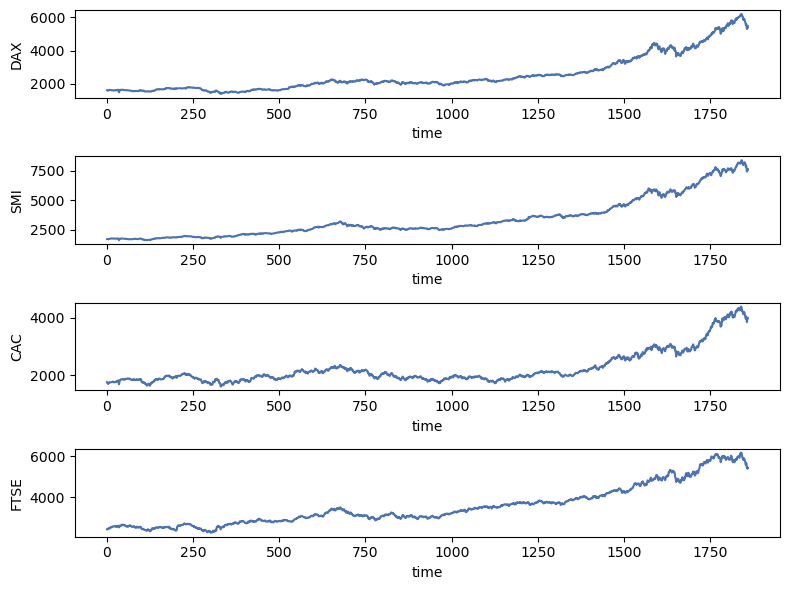

In [23]:
eustock = pd.read_csv("../data/pts/EuStockMarkets.csv").drop('rownames', axis=1)

fig, axes = plt.subplots(4, 1, figsize=(8,6))

so.Plot(eustock, x=eustock.index).add(so.Line(), y='DAX').on(axes[0]).label(x='time', y='DAX').plot()
so.Plot(eustock, x=eustock.index).add(so.Line(), y='SMI').on(axes[1]).label(x='time', y='SMI').plot()
so.Plot(eustock, x=eustock.index).add(so.Line(), y='CAC').on(axes[2]).label(x='time', y='CAC').plot()
so.Plot(eustock, x=eustock.index).add(so.Line(), y='FTSE').on(axes[3]).label(x='time', y='FTSE').plot()

plt.tight_layout()
plt.show()

### 3.1.2 히스토그램
- 시간축을 사용하면서, 시간 상 인접한 데이터간의 차이 및 히스토그램 측정 => 시간규모에 따라 시선이 달라짐

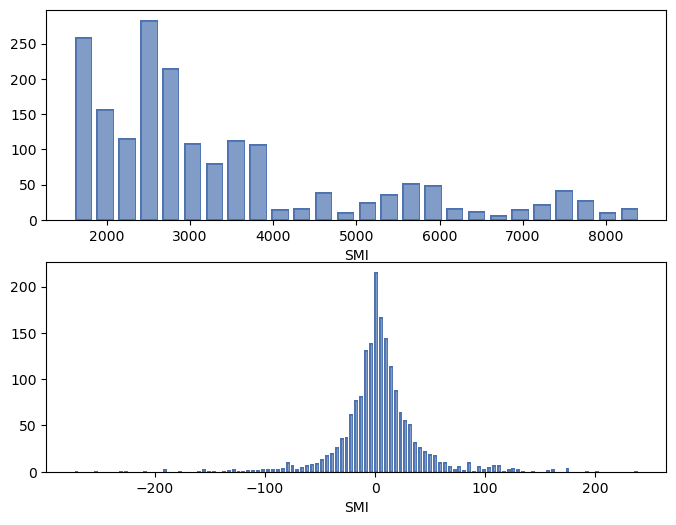

In [41]:
# 차분의 그래프는 추세상승을 이야기하지 않는다

fig, axes = plt.subplots(2, 1, figsize=(8,6))
so.Plot(eustock).add(so.Bar(), so.Hist(), x='SMI' ).on(axes[0]).plot()
so.Plot(eustock).add(so.Bar(), so.Hist(), x=eustock['SMI'].diff(1)).on(axes[1]).plot()

plt.show()

### 3.1.3 산점도
- 각 피쳐의 연관성 확인

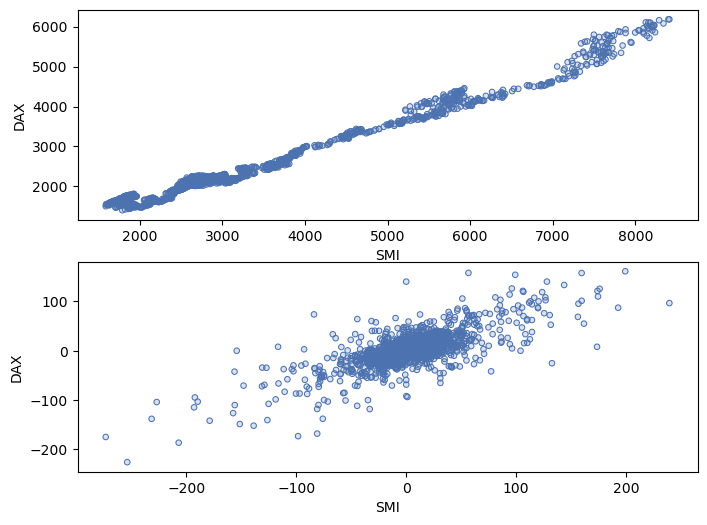

In [46]:
# 차분의 산점도는 강한 상관관계를 보이지 않는다
fig, axes = plt.subplots(2,1, figsize=(8,6))

so.Plot().add(so.Dots(), x=eustock['SMI'], y=eustock['DAX']).on(axes[0]).plot()
so.Plot().add(so.Dots(), x=eustock['SMI'].diff(1), y=eustock['DAX'].diff(1)).on(axes[1]).plot()

plt.show()

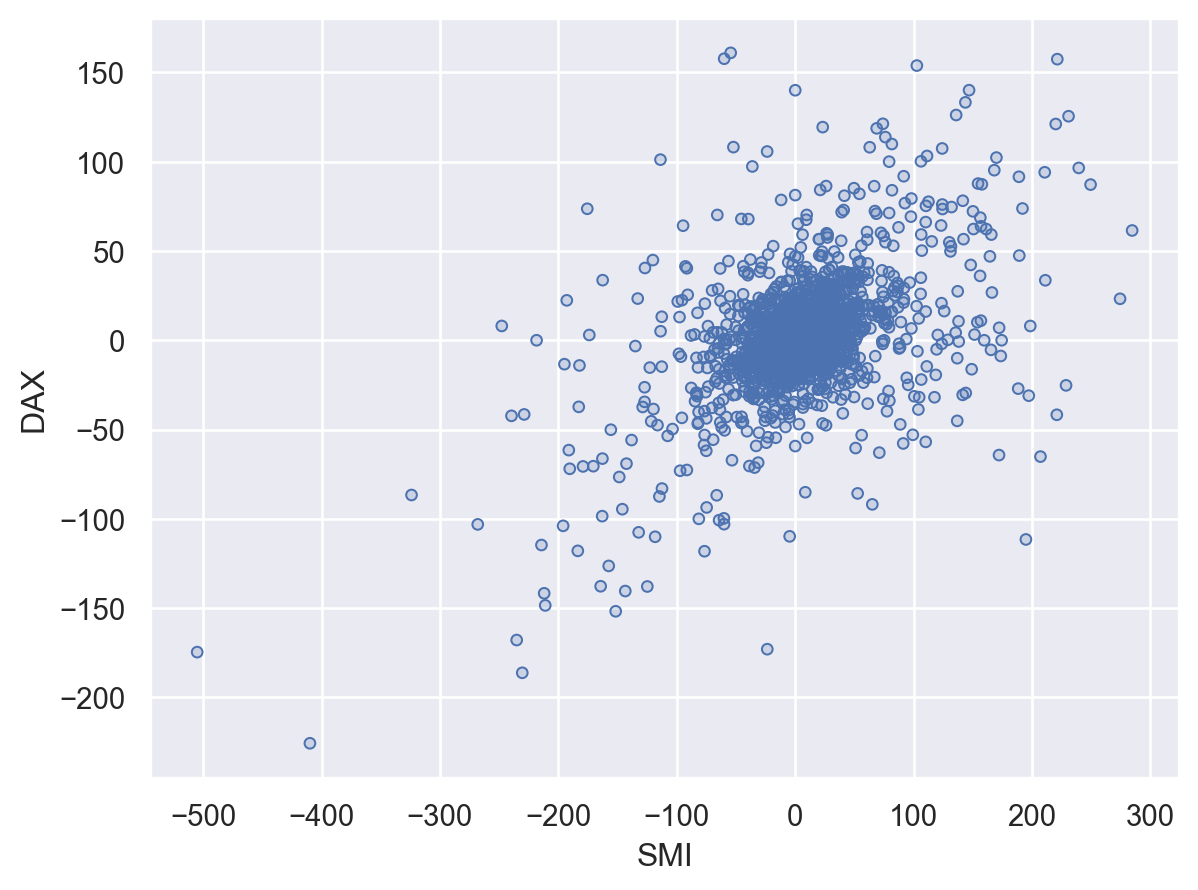

In [47]:
# 하나만 당겨도 상관관계가 사라짐
so.Plot().add(so.Dots(), x=eustock['SMI'].diff(2), y=eustock['DAX'].diff(1)).plot()

- 비시계열 데이터와 동일한 방법을 시계열 데이터에도 사용할 수 있으나, 제대로 동작하지 않을 것
- 시간에 딸느 변화나 서로 다른 시점의 데이터사이 관계가 데이터 동작방식 이해에 유익

## 3.2 시계열에 특화된 탐색법
- 개념
    - 정상성 : 시계열이 정상성이 된다는 의미와 정상성에 대한 통계적 검사, 안정성의 수준
    - 자체상관 : 시계열 그 자체로 연관성이 있음, 내부적 영ㄱ학의 존재
    - 허위상관 : 상관관계가 허위가 된다, 상관고나계가 곧 인과관계는 아님
### 3.2.1 정상성 이해하기
- 정상이 아닌 상태
1) 평균값이 일정하게 유지되기 보다 시간에 따라 증가
2) 연간 최고점과 최저점 사이의 간격이 증가 => 분산이 시간에 따라 증가
3) 강한 계절성
- 정상성 : 모든 시차 K에 대해 $y_t,\dots,y_{t+k}$의 분포가 t에 의존적이지 않은 경우
    - 단위근의 존재 유무, 그 과정의 특성방정식의 해가 1인지에 대한 질문 : 단위근이 있으면 비정상
- Augmented Dickey-Fuller 검정 : 시계열의 정상성 평가
$$\triangle y_t = y_t - y_{t-1} = \sum(\phi-1)\times y_{t-1}+\epsilon_t $$
    - H0 : 시계열에 단위근이 존재함, 비정상
- 수많은 시계열 모델이 정상성 가정
- 시계열 정상화 대표 변환 : 로그 & 제곱근 => 분산이 변화하는 경우 사용
- 변수에 대한 정규성 가정 : Box-Cox 변환으로 정규성
=> 이러한 변환들 후 데이터 간 거리의 의미 파악 필요 & 원본 데이터에서 중요했던 의미가 보존되는지 확ㅇ니 필요

### 3.2.2 윈도우 함수 적용
- 롤링 윈도우

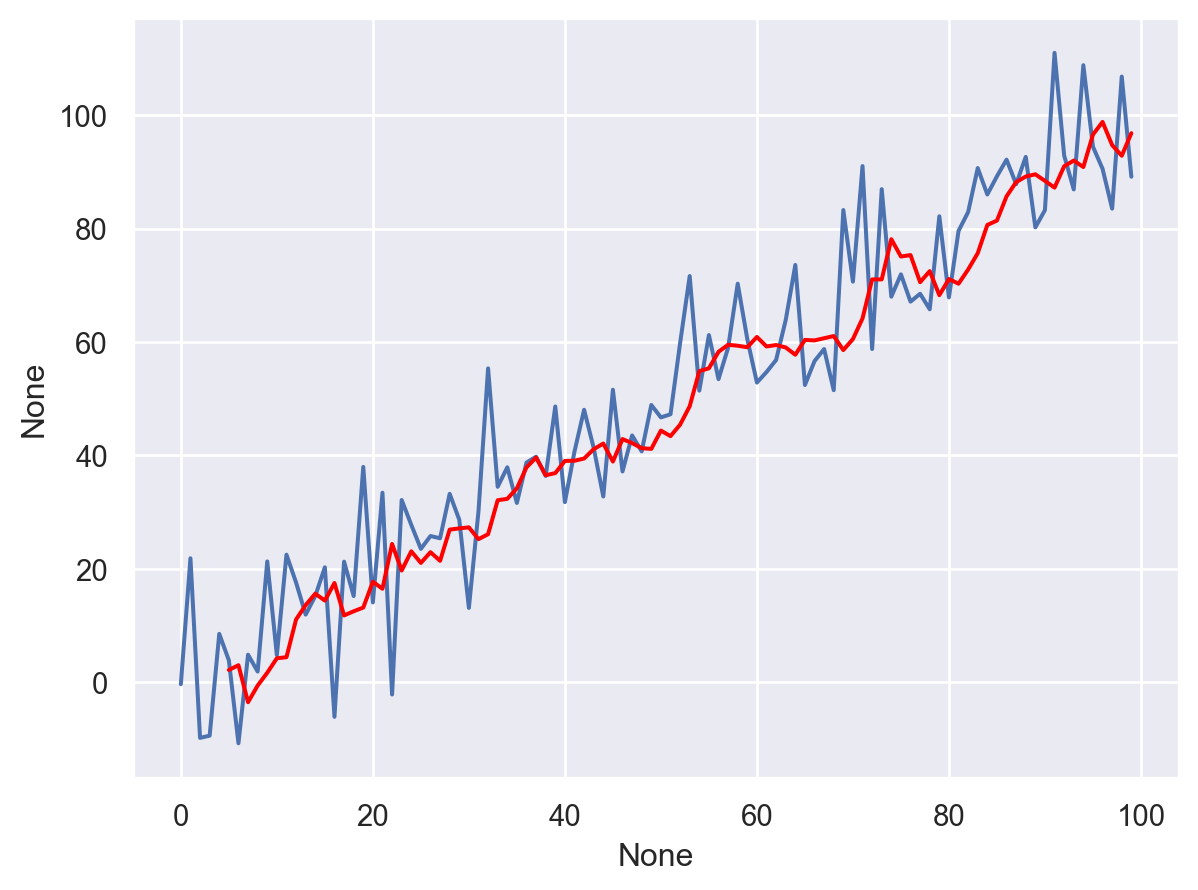

In [74]:
# 롤링 윈도우
temp = pd.Series(np.random.normal(0,10, size=100) + np.arange(1,101))
rolling_mean = temp.rolling(window=5, closed='left').mean()

so.Plot(x=temp.index).add(so.Line(), y=temp).add(so.Line(color='red'), y=rolling_mean).plot()

### 3.2.3 자체상관의 파악과 이해
- 특정 시점의 값이 다른 시점의 값과 상관관계
- 정상데이터의 ACF는 빠르게 0으로 떨어짐, 비정상일 경우 시차 1일 때 값은 큰 양수
- 자기상관(Auto-Correlation Function) : 서로 다른 시점의 데이터 간 선형적 연관성 정도를 시차에 대한 함수로 확인
    - ACF로부터 시차가 0인 지점의 상관관계는 1(모든 시계열 동일), 시차가 1인 지점은 0.5 
    - ACF의 주기함수는 원래 과정과 동일한 주기성
    - 주기함수들의 합의 자기상관은 각 개별함수에 대한 자기상관의 합
    - 양과 음의 시차에 관해서 대칭 => 양의 시차만 명백하게 고려
    - 0이 아닌 유효한 ACF 추정 : $+/-1.96 \times \sqrt{n} $, 충분히 큰 샘플 크기 및 과정의 유한분산에서만 유효
- 편자기상관(Partial Auto-Correlation Function) : 자신에 대한 그 시차의 편상관, 두 시점 사이에 모든 정보 고려
    - 많은 조건부 상관관계 계산 후, 전체부터 뺴야 함
- **ACF, PACF 값이 임계값을 벗어나면, 해당 시차에서 상관관계가 통계적으로 유의미!**

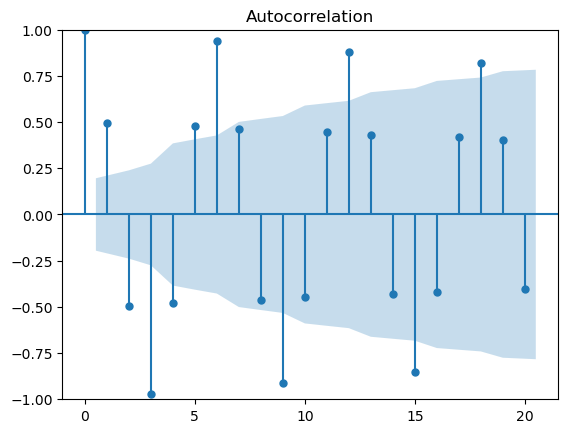

In [82]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
x = np.arange(1,101)
y = np.sin(x*np.pi / 3)

plot_acf(y);

In [96]:
# Auto-correlation 직접 계산
pd.concat([pd.Series(y), pd.DataFrame(y).shift(2)],axis=1).corr()

,0,0
0,1.000000,-0.503715
0,-0.503715,1.000000


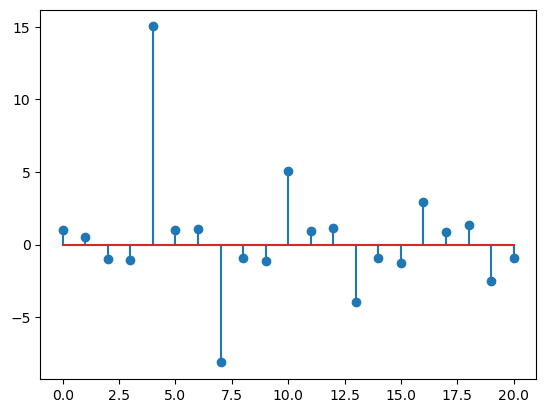

In [165]:
from statsmodels.tsa.stattools import acf, pacf
y = np.sin(x*np.pi/3)
acf_val = acf(y)
pacf_val = pacf(y)

plt.stem(np.arange(0,21), pacf_val)
plt.show()

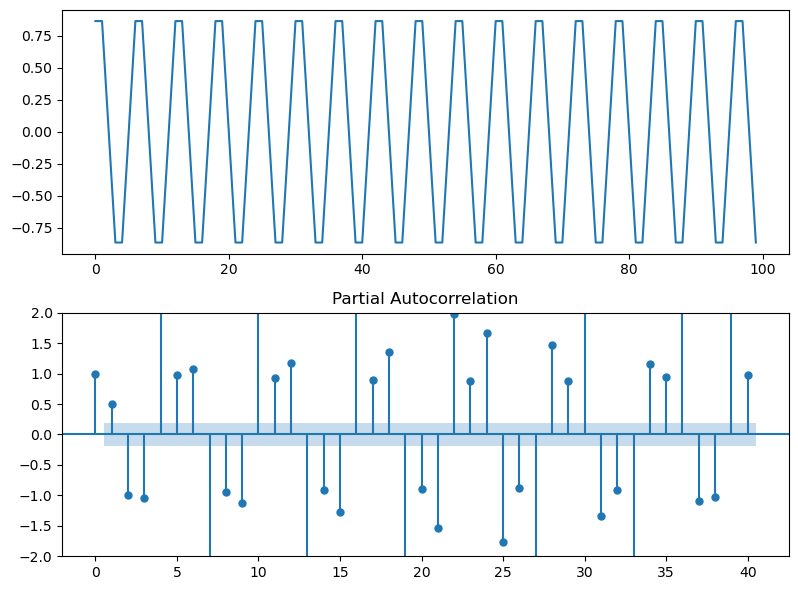

In [139]:
fig, axes = plt.subplots(2,1, figsize=(8,6))
plot_pacf(y, ax=axes[1], lags=40);
sns.lineplot(y, ax=axes[0]);
plt.ylim(-2,2)
plt.tight_layout();

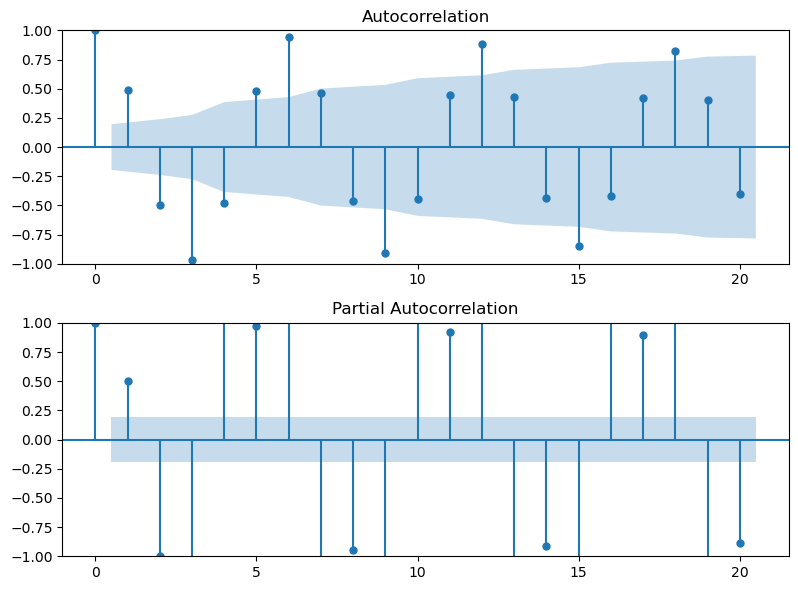

In [126]:
y1 = np.sin(x * np.pi / 3)

fig, axes = plt.subplots(2,1, figsize=(8,6))
plot_acf(y1, ax=axes[0])
plot_pacf(y1, ax=axes[1]);
plt.tight_layout()

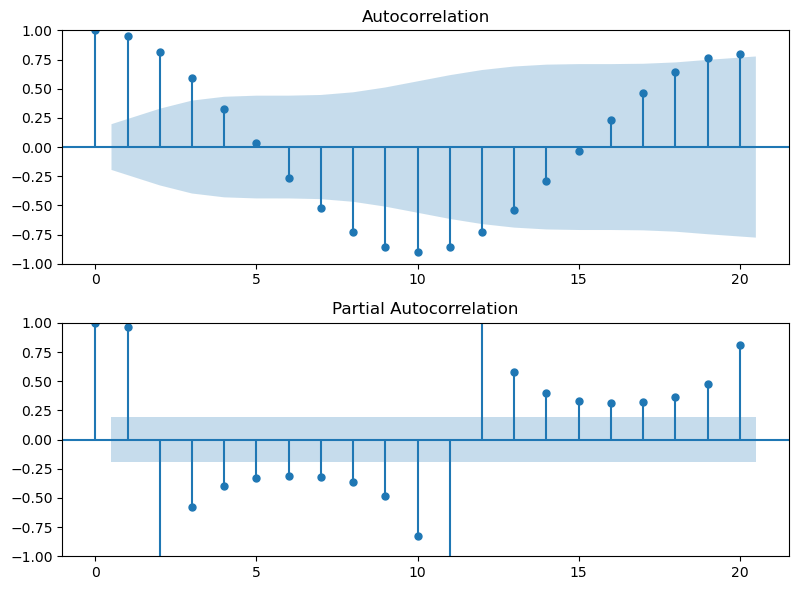

In [127]:
y2 = np.sin(x * np.pi / 10)

fig, axes = plt.subplots(2,1, figsize=(8,6))
plot_acf(y2, ax=axes[0])
plot_pacf(y2, ax=axes[1]);
plt.tight_layout()

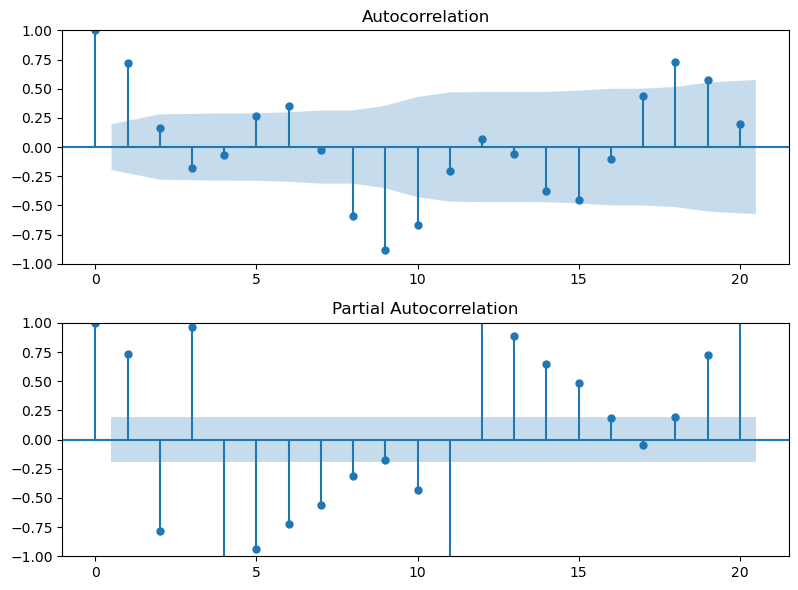

In [141]:
y = y1 + y2

fig, axes = plt.subplots(2,1, figsize=(8,6))
plot_acf(y, ax=axes[0])
plot_pacf(y, ax=axes[1]);
plt.tight_layout()

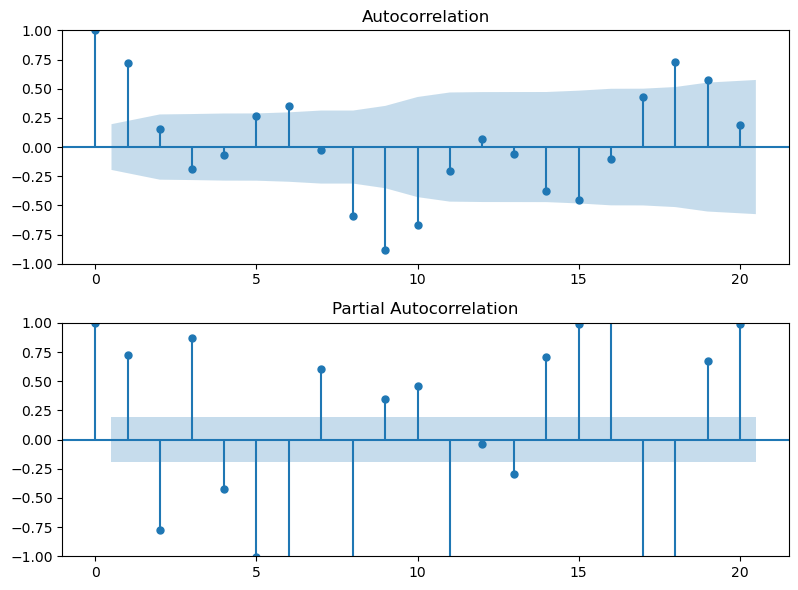

In [143]:
noise1 = np.random.normal(loc=0, scale=0.05, size=100)
noise2 = np.random.normal(loc=0, scale=0.05, size=100)

y1 = y1 + noise1
y2 = y2 + noise2
y = y1 + y2

fig, axes = plt.subplots(2,1, figsize=(8,6))
plot_acf(y, ax=axes[0]);
plot_pacf(y, ax=axes[1]);
plt.tight_layout()

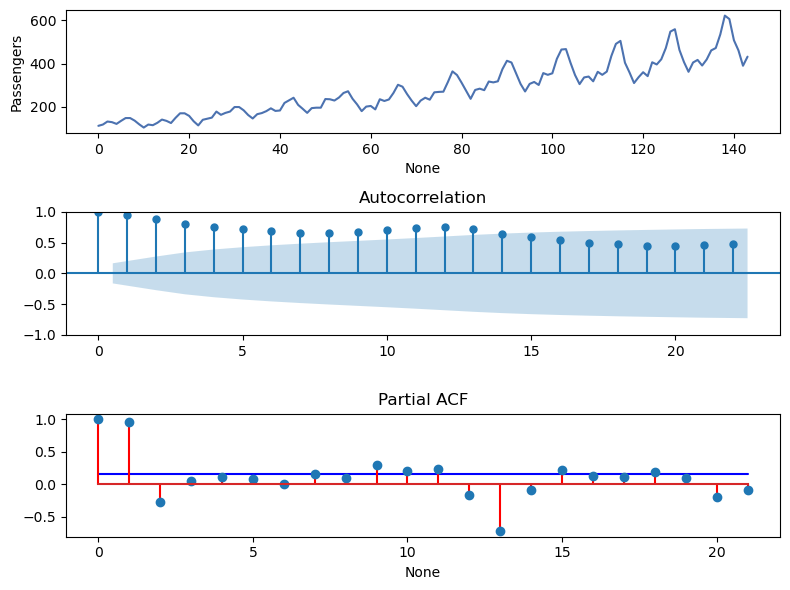

In [181]:
# ACF 임계값
air = pd.read_csv("https://raw.githubusercontent.com/PracticalTimeSeriesAnalysis/BookRepo/master/Ch02/data/AirPassengers.csv", names=['Date', 'Passengers'])

fig, axes = plt.subplots(3,1, figsize=(8,6))
so.Plot(x=air.index, y=air['Passengers']).add(so.Line()).on(axes[0]).plot();
plot_acf(air['Passengers'], ax=axes[1]);
so.Plot(x=air.index[:len(pacf(air['Passengers']))]).add(so.Line(color='blue'), y=np.ones(len(air))*1.96/np.sqrt(len(air))).on(axes[2]).label(title='Partial ACF').plot();
axes[2].stem(air.index[:len(pacf(air['Passengers']))], pacf(air['Passengers']), linefmt='r-')
plt.tight_layout()

### 3.2.4 허위상관
- 허위상관 시계열의 일반적 특징 => 분명한 원인 무엇인지 확인 필요
1) 계절성 : 핫도그 소비 vs 익사(여럼)
2) 시간이 지나면서 변한 데이터의 수준이나 경사의 이동(무의미하게 높은 상관관계)
3) 누적합계 속임수

## 3.3 유용한 시각화
### 3.3.1 1차원 시각화
- 여러 측정 구성단위가 있는 경우 여러 시계열을 동시 고려

In [183]:
donations = pd.read_csv("https://raw.githubusercontent.com/PracticalTimeSeriesAnalysis/BookRepo/master/Ch02/data/donations.csv")
donations.head()

,amount,timestamp,user
0,25.0,2017-11-12 11:13:44,0.0
1,50.0,2015-08-25 19:01:45,0.0
2,25.0,2015-03-26 12:03:47,0.0
3,50.0,2016-07-06 12:24:55,0.0
4,50.0,2016-05-11 18:13:04,1.0


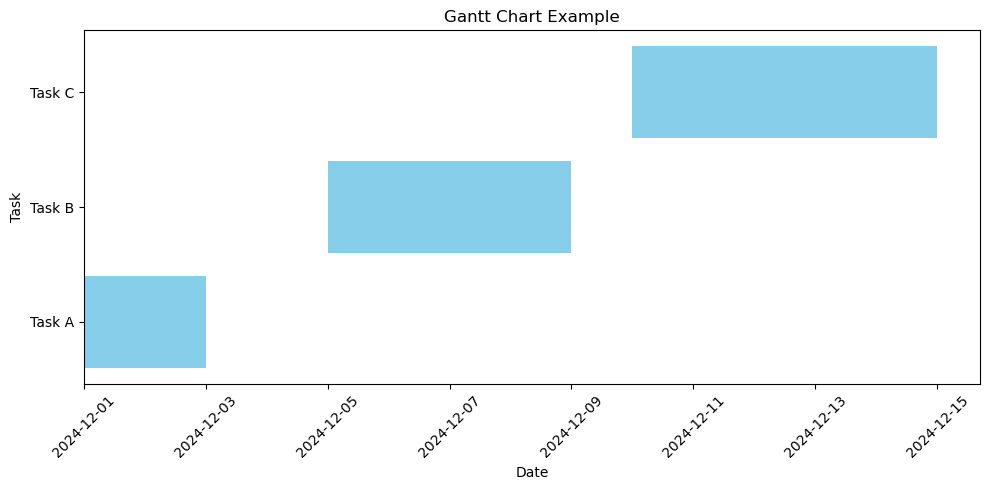

In [182]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# 데이터 생성
tasks = ["Task A", "Task B", "Task C"]
start_dates = [datetime(2024, 12, 1), datetime(2024, 12, 5), datetime(2024, 12, 10)]
durations = [2, 4, 5]  # 기간 (일 단위)

# 막대 데이터
fig, ax = plt.subplots(figsize=(10, 5))
for i, (task, start, duration) in enumerate(zip(tasks, start_dates, durations)):
    ax.barh(task, duration, left=start, color="skyblue")

# 날짜 포맷 설정
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.title("Gantt Chart Example")
plt.xlabel("Date")
plt.ylabel("Task")
plt.tight_layout()
plt.show()

### 3.3.2 2차원 시각화
- 선형 그래프

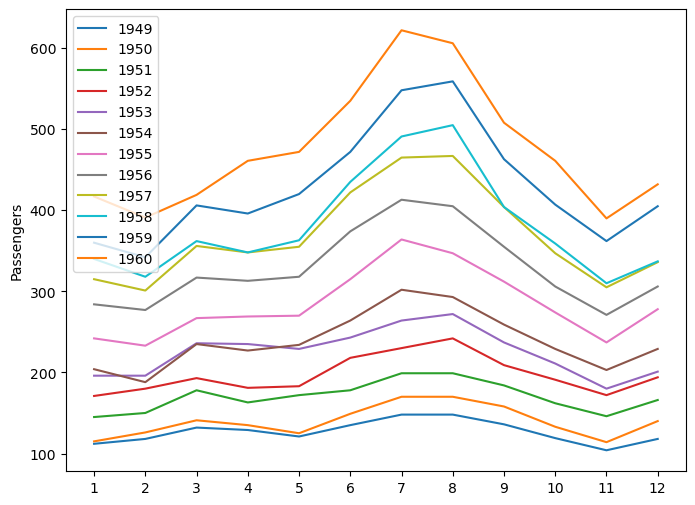

In [213]:
air = pd.read_csv("https://raw.githubusercontent.com/PracticalTimeSeriesAnalysis/BookRepo/master/Ch02/data/AirPassengers.csv", names=['Date', 'Passengers'])
air['Date'] = pd.to_datetime(air['Date'])
air['year'] = air['Date'].dt.year
air['month'] = air['Date'].dt.month

fig, ax = plt.subplots(figsize=(8,6))

for year in air['year'].unique():
    sns.lineplot(x=np.arange(1,len(air['year'].unique())+1), y=air.loc[air['year']==year,'Passengers'], label=year, ax=ax)
plt.xticks(np.arange(1,len(air['year'].unique())+1))
plt.show()

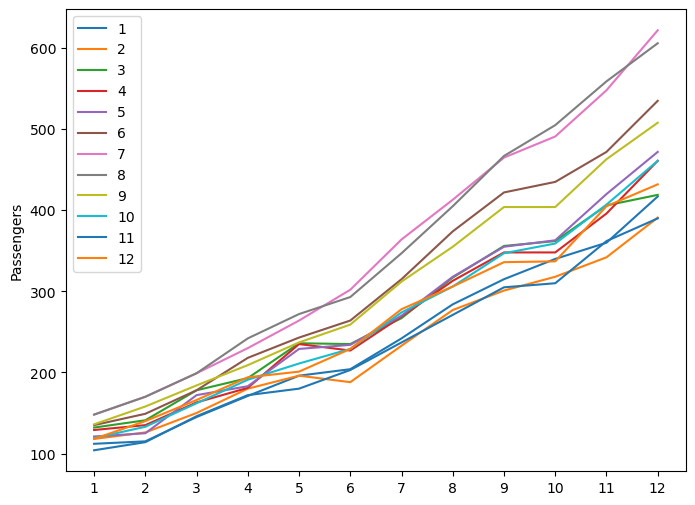

In [214]:
fig, ax = plt.subplots(figsize=(8,6))

for month in air['month'].unique():
    sns.lineplot(x=np.arange(1,len(air['month'].unique())+1), y=air.loc[air['month']==month,'Passengers'], label=month, ax=ax)
plt.xticks(np.arange(1,len(air['month'].unique())+1))
plt.show()